In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import pathlib
import os
import sklearn.model_selection
from tensorflow.keras import layers, Sequential, Model
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from typing import Type

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
def extract_label(file_path: tf.Tensor):
    """
    :param file_path: a tf.Tensor object created by iterating over a tf.data.Dataset generator 
    :return label: ground truth label for the image with corresponding file_path
    This function is to be used for extracting ground_truth labels from file paths
    """
    # str(file_path) will have a format like below:
    # "tf.Tensor(b'samples/yxd7m.png', shape=(), dtype=string)"
    # we only want "yxd7m" as a label
    label = str(file_path)[str(file_path).find("samples/") + len("samples/"):str(file_path).find(".png")]
    return label
def extract_all_charachters(ds: tf.data.Dataset):
    """
    :param ds: a tf.data.Dataset generator
    :return all_charachter: all characters that are used to create captcha images
    This function is to be used for getting all possible characters in captcha images.
    """
    all_charachter = []
    for file_path in ds:
        label = extract_label(file_path)
        all_charachter.extend(list(label))
    all_charachter = np.array(all_charachter)
    all_charachter = np.unique(all_charachter)
    return all_charachter

In [3]:
directory = "samples/"
ds = tf.data.Dataset.list_files(str(pathlib.Path(directory+"*.png")), shuffle=True, seed=1)
# seperating the dataset into test-set(validation-set actually) and training-set
test_portion = 0.2
ds_test = ds.take(int(len(ds) * test_portion))
ds_train = ds.skip(int(len(ds) * test_portion))

print(f"length of the whole dataset is: {len(ds)}")
print(f"length of the train dataset is: {len(ds_train)}")
print(f"length of the test dataset is: {len(ds_test)}")

length of the whole dataset is: 1040
length of the train dataset is: 832
length of the test dataset is: 208


In [4]:
# Extracting all possible characters
all_charachter = extract_all_charachters(ds)

In [5]:
def one_hot_encoder(all_charachter: np.array):
    """
    :param all_charachter: all characters that are used to create captcha images
    :return enc: a fitted sklearn OneHotEncoder to transform string labels to matrix labels
    this function is to be used for OneHot-encoding characters, and it returns a sklearn encoder object.
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(all_charachter.reshape(-1, 1))
    return enc
enc = one_hot_encoder(all_charachter)

In [6]:
# the number of supported charachters for model
n_features = len(all_charachter)
# the supported length of captcha labels for model
n_timesteps_in = 5

In [7]:
def label_to_array(inputs: str):
    """
    :param inputs: a string label
    :return outputs: corresponding OneHotEncoded label to be used in training
    This function uses the one_hot_encoder to encode labels into a (n_timesteps_in, n_features) vector
    """
    outputs = []
    for label in inputs:
        tmp_list = list(label)
        output = [None] * len(label)
        for i in range(len(label)):
            output[i] = enc.transform(np.array(label[i]).reshape(-1,1)).toarray()
        output = np.array(output)
        outputs.append(output)
        
    return np.array(outputs)

def array_to_label(array):
    """
    :param array: a OneHotEncoded label
    :return: corresponding string label
    This function converts a (n_timesteps_in, n_features) vector to an array of length (n_timesteps_in, )
    """
    try:
        return all_charachter[np.array(array).argmax(axis=3)].reshape(-1)
    except:
        y = np.array(array).astype('<U7')
        y = label_to_array(y)
        y = y.reshape(-1, n_timesteps_in, n_features)
        return all_charachter[np.array(y).argmax(axis=2)].reshape(-1)


In [8]:
def process_path(file_path: tf.Tensor):
    """
    :param file_path: a tf.Tensor object created by iterating over a tf.data.Dataset generator 
    :return image: image with the corresponding file_path to be used in training
    :return label: label for the corresponding file_path
    This function is to be applied (by using .map) to a tf.data.Dataset object in order to extract (x, y) for training
    """
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image)   
    
    label = tf.strings.substr(file_path, pos=len("samples/"), len=n_timesteps_in)
    return image, label

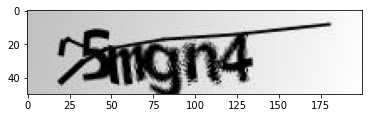

['5' 'm' 'g' 'n' '4']


In [9]:
# using the defined functions to read an image file and its label
for (image_temp, label_temp) in ds_train.map(process_path).batch(1):
    break 
# saving the image dimensions    
image_height = image_temp.shape[1]
image_width = image_temp.shape[2]
# plotting the image
image_temp = np.array(image_temp).reshape(image_height, image_width, -1)
plt.imshow(image_temp)
plt.show()
print(array_to_label(label_temp))

In [10]:
def process_image(image: tf.Tensor, training: bool=False):
    """
    :param image: an image created by reading a .png file with 4 channels
    :return image: an image with one grayscale channel and a determined size
    this function removes extra channels and also makes sure that the image size is acceptable by model.
    """
    image = image[:, :, :, 0:-1]
    image = tf.image.resize(image, (image_height, image_width))
    image = tf.image.rgb_to_grayscale(image)
    return image

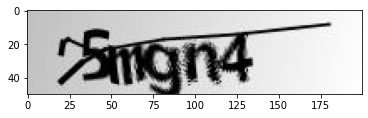

In [11]:
image1 = process_image(image_temp.reshape(1, image_height, image_width, -1), training=True)
plt.imshow(image1.numpy().reshape(image_height, image_width, -1), cmap="gist_gray")
plt.show()

In [12]:
class vgg_block(layers.Layer):
    def __init__(self, n_filters: int):
        """
        :param n_filters: number of filters of the output image
        """
        super().__init__()
        self.n_filters = n_filters
        self.conv1 = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')
        self.BN1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')
        self.BN2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')
        self.BN3 = layers.BatchNormalization()
    def call (self, layer_in: tf.Tensor, training: bool=False):
        """
        :param layer_in: the input image
        :return layer_in: the image created by applying a vgg block on the input image
        """
        layer_in = self.conv1(layer_in)
        layer_in = self.BN1(layer_in)
        layer_in = self.conv2(layer_in)
        layer_in = self.BN2(layer_in)
        layer_in = self.conv3(layer_in)
        layer_in = self.BN3(layer_in)
        layer_in = layers.AveragePooling2D((2,2), strides=(2,2))(layer_in)
        return layer_in
    pass

In [13]:
class my_model(tfk.Model):
    def __init__(self):
        """
        instantiating a CNN + LSTM model
        """
        super().__init__()
        self.augm1 = tf.keras.layers.RandomBrightness(0.4)
        self.augm2 = tf.keras.layers.RandomContrast(0.4)
        self.augm3 = tf.keras.layers.RandomRotation(0.01, fill_mode='nearest', interpolation='bilinear')
        self.augm4 = tf.keras.layers.RandomZoom(height_factor=(-0.10, 0.10), fill_mode='nearest')
        self.vgg1 = vgg_block(32)
        self.drop1 = layers.Dropout(0.2)
        self.vgg2 = vgg_block(64)
        self.drop2 = layers.Dropout(0.2)
        # LSTM input: A 3D tensor with shape [batch, timesteps, feature].
        # we want the "timesteps" dimension of LSTM input to be something meaningful.
        # as humans read from left-to-right or right-to-left, we want model to have the same approach
        # so we treat "width" dimension as timesteps, so we use reshape like below:
        self.reshape1 = layers.Reshape(((int(image_width / 4), -1)))
        self.lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
        self.reshape2 = layers.Reshape(((n_timesteps_in, -1)))
        self.dense1 = layers.Dense(256)
        self.dense2 = layers.Dense(n_features, activation='softmax')
    def call(self, inputs: tf.Tensor, training=False):
        """
        :param inputs: the input image
        :return: output of shape (batchsize, n_timesteps_in, n_features)
        """
        x = self.augm1(inputs)
        x = self.augm2(x)
        x = self.augm3(x)
        x = self.augm4(x)
        x = self.vgg1(x)
        x = self.drop1(x)
        x = self.vgg2(x)
        x = self.drop2(x)
        x = self.reshape1(x)
        x = self.lstm(x)
        x = self.reshape2(x)
        x = self.dense1(x)
        return self.dense2(x)
    def model(self):
        """
        :return: a model created by using keras functional API
        """
        x = layers.Input(shape=(image_height, image_width, 1))
        return Model(inputs=x, outputs=self.call(x))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 200, 1)]      0         
                                                                 
 random_brightness (RandomBr  (None, 50, 200, 1)       0         
 ightness)                                                       
                                                                 
 random_contrast (RandomCont  (None, 50, 200, 1)       0         
 rast)                                                           
                                                                 
 random_rotation (RandomRota  (None, 50, 200, 1)       0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 50, 200, 1)        0         
                                                             

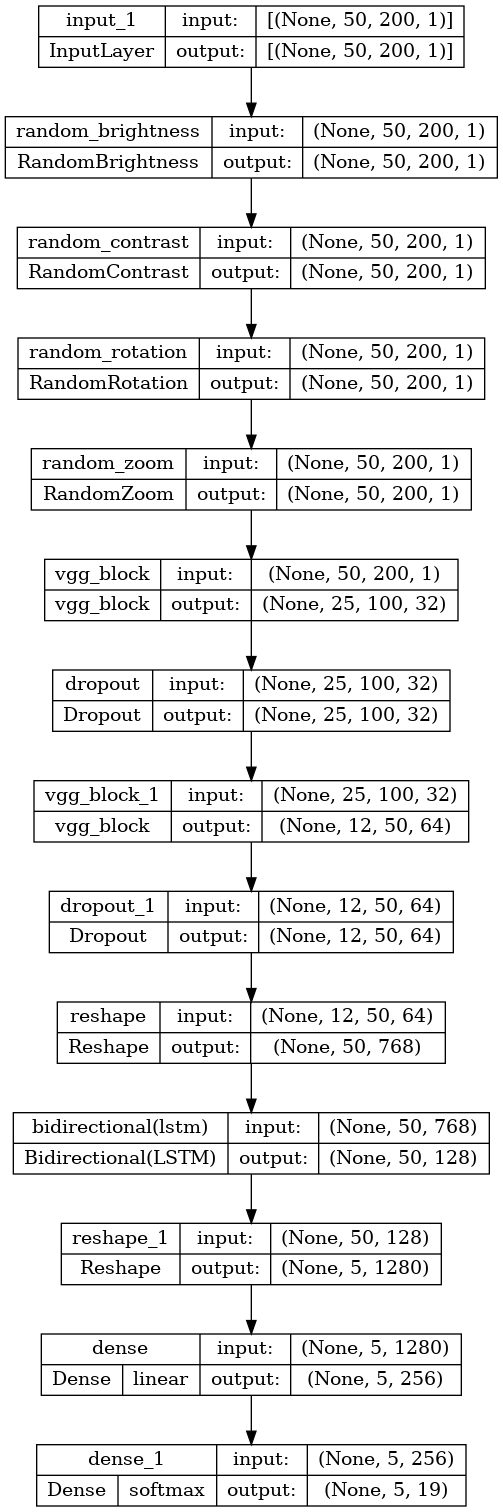

In [14]:
model = my_model()
model = model.model()
model.summary()
plot_model(model, show_layer_activations=True, show_shapes=True, to_file='model2.png')

In [15]:
num_epochs = 50
batch_size = 64
lossess = []
accuracies = []
def start_training():
    """
    starts the training process
    """
    criterion = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam()
    acc_metric = tfk.metrics.CategoricalAccuracy()
    for epoch in range(num_epochs):
        for batch_idx, (x, y) in enumerate(ds_train.map(process_path).batch(batch_size)):
            y = np.array(y).astype('<U7')
            y = label_to_array(y)
            y = y.reshape(-1, n_timesteps_in, n_features)
            x = process_image(x, training=True)
            with tf.GradientTape() as tape:
                y_pred = model(x, training=True)
                loss = criterion(y, y_pred)
            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            acc_metric.update_state(y, y_pred)
            print(f"Batch {batch_idx + 1} completed")
        train_acc = acc_metric.result()
        lossess.append(loss)
        accuracies.append(train_acc)
        print(f"accuracy after epoch {epoch+1} is {train_acc}")
        acc_metric.reset_state()
start_training()

Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed


Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 1 is 0.06899038702249527
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed


Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 2 is 0.08437500149011612
Batch 1 completed
Batch 2 completed
Batch 3 completed


Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 3 is 0.1112980768084526


Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed


Batch 12 completed
Batch 13 completed
accuracy after epoch 4 is 0.16129808127880096
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed


Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 5 is 0.23028846085071564
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed


Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 6 is 0.3129807710647583
Batch 1 completed
Batch 2 completed
Batch 3 completed


Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 7 is 0.3954326808452606


Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed


Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 8 is 0.46610575914382935
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed


Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 9 is 0.5189903974533081
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed


Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 10 is 0.5709134340286255
Batch 1 completed
Batch 2 completed
Batch 3 completed


Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 11 is 0.6276442408561707


Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed


Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 12 is 0.6502403616905212
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed


Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 13 is 0.6764423251152039
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed


Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 14 is 0.706250011920929
Batch 1 completed
Batch 2 completed


Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 15 is 0.7228365540504456


Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed


Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 16 is 0.7401442527770996
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed


Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 17 is 0.7646634578704834
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed


Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 18 is 0.7853365540504456
Batch 1 completed
Batch 2 completed


Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed


Batch 13 completed
accuracy after epoch 19 is 0.7932692170143127
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed


Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 20 is 0.8120192289352417
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed


Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 21 is 0.8216345906257629
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed


Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 22 is 0.831250011920929
Batch 1 completed
Batch 2 completed


Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed


Batch 13 completed
accuracy after epoch 23 is 0.8459134697914124
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed


Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 24 is 0.8536057472229004
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed


Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 25 is 0.8644230961799622
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 26 is 0.8699519038200378
Batch 1 completed
Batch 2 completed


Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed


Batch 13 completed
accuracy after epoch 27 is 0.8841345906257629
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed


Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 28 is 0.8790865540504456
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed


Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 29 is 0.890625
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 30 is 0.8978365659713745
Batch 1 completed
Batch 2 completed


Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed


Batch 13 completed
accuracy after epoch 31 is 0.901442289352417
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed


Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 32 is 0.9055288434028625
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed


Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 33 is 0.9163461327552795
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 34 is 0.9185096025466919
Batch 1 completed


Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed


Batch 13 completed
accuracy after epoch 35 is 0.9211538434028625
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed


Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 36 is 0.9271634817123413
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed


Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 37 is 0.9305288195610046
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 38 is 0.9372596144676208
Batch 1 completed


Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed


Batch 13 completed
accuracy after epoch 39 is 0.9350961446762085
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed


Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 40 is 0.9456730484962463
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed


Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 41 is 0.9355769157409668
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 42 is 0.9437500238418579
Batch 1 completed


Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed


Batch 12 completed
Batch 13 completed
accuracy after epoch 43 is 0.9451923370361328
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed


Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 44 is 0.9512019157409668
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed


Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 45 is 0.953125
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 46 is 0.9504807591438293
Batch 1 completed


Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed


Batch 12 completed
Batch 13 completed
accuracy after epoch 47 is 0.9459134340286255
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed


Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 48 is 0.9509615302085876
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed


Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 49 is 0.9536057710647583
Batch 1 completed
Batch 2 completed
Batch 3 completed


Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed
accuracy after epoch 50 is 0.9673076868057251


In [18]:
def start_testing():
    """
    starts the testing process
    """
    acc_metric = tfk.metrics.CategoricalAccuracy()
    acc_metric.reset_state()
    for batch_idx, (x, y) in enumerate(ds_test.map(process_path).batch(64)):
        y = np.array(y).astype('<U7')
        y = label_to_array(y)
        y = y.reshape(-1, n_timesteps_in, n_features)
        x = process_image(x, training=True)
        y_pred_test = model(x)
        acc_metric.update_state(y, y_pred_test)
    test_acc = acc_metric.result()
    print(f"accuracy on test set is {test_acc}")
start_testing()

accuracy on test set is 0.9798076748847961


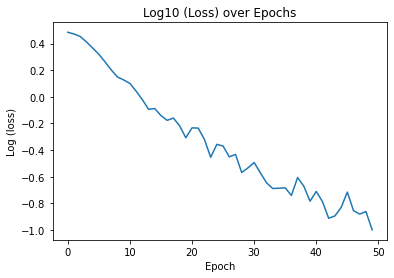

In [28]:
plt.plot(np.log10(np.array(lossess)))
plt.title("Log10 (Loss) over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Log (loss)")
plt.savefig('loss.png')

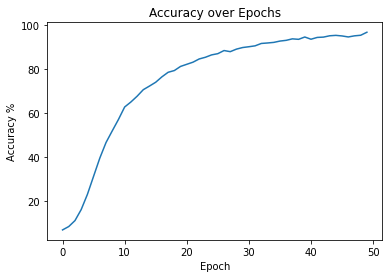

In [29]:
plt.plot(np.array(accuracies) * 100)
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.savefig('accuracy.png')